In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# plyaer data load 및 정리(프로필)
player_df = pd.read_csv('./data/new/players_all.csv')
player_df = player_df.rename(columns={'Unnamed: 0':'Id'}).drop(['Id'], axis=1)

# 1xbet data load 및 정리(스텟)
xbet_df = pd.read_csv('./data/new/1xbet_all.csv')
xbet_df = xbet_df.drop(['Team','Age','Position'], axis=1).rename(columns={'Drb_x':'Drb_Off', 'Drb_y':'Drb_Def'})

# understat data load 및 정리(스텟)
understat_df = pd.read_csv('./data/new/understat_all.csv')
understat_df = understat_df.drop(['No','Team'], axis=1)

# capology load(연봉)
capology_df = pd.read_csv('./data/new/capology_all.csv')

# 프로필 + 연봉
eda_df = player_df.merge(capology_df[['Weekly Salary','Base Salary','ADJ Salary','Name', 'year']],
                         how='left', left_on=['Name', 'year'], right_on=['Name', 'year'])
eda_df = eda_df[~eda_df.duplicated(['year', 'Name'], keep='first')] # 중복 제거
# 프로필 + 연봉 + 스텟(understat)
eda_df = eda_df.merge(understat_df, how='left', left_on=['Name', 'year'], right_on=['Name', 'year'])
# 프로필 + 연봉 + 스텟(understat) + 스텟(1xbet)
eda_df = eda_df.merge(
    xbet_df[[
        'Name', 'year', 'SpG', 'KeyP', 'Drb_Off', 'Fouled', 'Off',
        'Disp', 'UnsTch', 'Rating', 'Tackles', 'Inter','Fouls',
        'Offsides', 'Clear', 'Drb_Def', 'Blocks', 'AvgP', 'PS%']],
    how='left',
    left_on=['Name', 'year'],
    right_on=['Name', 'year']
)

In [2]:
eda_df = eda_df.dropna()
round(eda_df.describe(), 2)

,Player Id,Birth Year,Age,year,Weekly Salary,Base Salary,ADJ Salary,Apps,Min,G,...,Rating,Tackles,Inter,Fouls,Offsides,Clear,Drb_Def,Blocks,AvgP,PS%
count,4588.00,4588.00,4588.00,4588.00,4588.00,4588.00,4588.00,4588.00,4588.00,4588.00,...,4588.00,4588.00,4588.00,4588.00,4588.00,4588.00,4588.00,4588.00,4588.00,4588.00
mean,129453.85,1992.02,25.91,2017.93,53921.12,2803898.52,3076834.48,20.58,1466.58,1.96,...,6.65,1.12,0.78,0.70,0.13,1.53,0.61,0.22,29.00,76.91
std,119957.91,4.93,4.21,2.60,52782.05,2744666.44,2942732.53,11.49,1032.21,3.52,...,0.36,0.84,0.70,0.46,0.23,1.75,0.48,0.29,16.44,12.42
min,17.00,1973.00,15.00,2014.00,0.00,0.00,0.00,1.00,1.00,0.00,...,4.95,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,31281.00,1989.00,23.00,2016.00,20000.00,1040000.00,1252784.00,11.00,532.50,0.00,...,6.40,0.50,0.18,0.38,0.00,0.33,0.25,0.00,17.00,72.73
50%,91387.00,1992.00,26.00,2018.00,40000.00,2080000.00,2301310.00,22.00,1390.00,1.00,...,6.65,1.00,0.65,0.68,0.00,0.86,0.53,0.11,27.29,79.32
75%,145392.00,1996.00,29.00,2020.00,70000.00,3640000.00,4071549.00,31.00,2326.25,2.00,...,6.88,1.63,1.20,1.00,0.15,2.09,0.88,0.33,38.44,84.32
max,470690.00,2005.00,41.00,2022.00,600000.00,31200000.00,33671679.00,38.00,3420.00,36.00,...,8.34,7.00,4.22,4.00,2.00,11.50,4.00,2.05,90.41,100.00


In [3]:
eda_df.columns

Index(['Player Id', 'Name', 'Birth Year', 'Age', 'Team', 'Position', 'year',
       'Weekly Salary', 'Base Salary', 'ADJ Salary', 'Apps', 'Min', 'G', 'NPG',
       'A', 'xG', 'NPxG', 'xA', 'xGChain', 'xGBuildup', 'xG90', 'NPxG90',
       'xA90', 'xG90+xA90', 'NPxG90+xA90', 'xGChain90', 'xGBuildup90', 'SpG',
       'KeyP', 'Drb_Off', 'Fouled', 'Off', 'Disp', 'UnsTch', 'Rating',
       'Tackles', 'Inter', 'Fouls', 'Offsides', 'Clear', 'Drb_Def', 'Blocks',
       'AvgP', 'PS%'],
      dtype='object')

# 특정 선수와의 활동 비교
* sample  data 추출
    *  출전 시간(평균이상)
    * 출전 경기(평균이상)
    * 연봉(top100)
* Age Leveling 하기
* Age Leveling 별 평균치

In [4]:
min_mean = eda_df['Min'].mean()
min_mean

1466.5843504795118

In [5]:
apps_mean = eda_df.Apps.mean()
apps_mean

20.581952920662598

In [6]:
# 전체 연봉 정리
salary_list = eda_df[['Name', 'Weekly Salary']].groupby(['Name', 'Weekly Salary'])\
            .count().sort_values(by = 'Weekly Salary', ascending = False)
salary_list.head()

,
Name,Weekly Salary
Gareth Bale,600000.0
Cristiano Ronaldo,515000.0
Kevin De Bruyne,400000.0
David de Gea,375000.0
Erling Haaland,375000.0


In [7]:
# eda_df['Age Lev'] = eda_df['Age'].apply(lambda age: '<23' if age < 23 else '<25' if age <25 else '<27' if age<27 else '<30' if age<30 else '<33' if age<33 else '>33')
eda_df['Age Lev'] = eda_df['Age'].apply(lambda age: '<21' if age < 21 else '21' if age ==21 else '22' if age == 22
                                        else '23' if age == 23 else '24' if age == 24 else '25' if age == 25
                                        else '26' if age == 26 else '27' if age == 27 else '28' if age == 28
                                        else '29' if age == 29 else '30' if age == 30 else '31' if age == 31
                                        else '32' if age == 32 else '>32' )
eda_df['Age Lev'].unique()

array(['23', '25', '26', '27', '29', '30', '28', '22', '24', '31', '>32',
       '21', '<21', '32'], dtype=object)

In [8]:
# '23', '25', '26', '27', '29', '30', '28', '22', '24', '31', '>32', '21', '<21', '32'
def get_age_lev(age):
    if age < 21:
        return '<21'
    elif age < 22:
        return '21'
    elif age < 23:
        return '22'
    elif age < 24:
        return '23'
    elif age < 25:
        return '24'
    elif age < 26:
        return '25'
    elif age < 27:
        return '26'
    elif age < 28:
        return '27'
    elif age < 29:
        return '28'
    elif age < 30:
        return '29'
    elif age < 31:
        return '30'
    elif age < 32:
        return '31'
    elif age < 33:
        return '32'
    else:
        return '>32'    

## 각 포지션 별 특정 대표 지표 정하기

### 공격수 
공격 지표 : 'G', 'A', 'NPG', 'xGBuildup', 'Drb_Off', 'PS%'
### 미드필더 
공격 지표 : 'G', 'A', 'xGBuildup', 'Drb_Off', 'KeyP', 'PS%'  
### 수비수 
공격 지표 : 'xGBuildup', 'PS%'   
수비 지표 : 'Inter', 'Clear', 'Blocks', 'Drb_Def'

### 모든 지표는 동나이대 동표지션과 비교할 것

In [70]:
stats = {'feature' : ['year', 'Name', 'Age', 'Team', 'Position', 'Weekly Salary',
       'Base Salary', 'ADJ Salary', 'Apps', 'Min', 'G', 'NPG', 'A', 'xG',
       'NPxG', 'xA', 'xGBuildup', 'SpG', 'KeyP',
       'Drb_Off', 'Fouled', 'Off', 'Disp', 'UnsTch', 'Rating', 'Tackles',
       'Inter', 'Fouls', 'Offsides', 'Clear', 'Drb_Def', 'Blocks', 'AvgP', 'PS%'],
        'mean' : ['년도', '이름', '나이', '소속팀', '포지션', '주급', '연봉', '물가 조정 연봉', '출전 경기', '출전 시간', 
        '골', '패널티킥 제외 골', '도움', '기대 골', '패널티 킥 제외 기대 골', '기대 도움', '특점 확률이 높은 상황에 관여한 정도', 
        '경기 당 슈팅 횟수', '키패스 (슈팅으로 이어진 패스)', '드리블 성공', '파울 얻어낸 것', '오프사이드', '패스미드 등으로 볼 소유권 잃음', 
        '드리블 중 볼 소유권 잃음', '평점', '태클 횟수', '인터셉트', '파울한 것', '오프사이드 유도', '볼 클리어 횟수', '드리블 허용',
        '볼 블락', '경기당 패스 횟수', '패스 성공률']}

Feature_name = pd.DataFrame(stats)
Feature_name

,feature,mean
0,year,년도
1,Name,이름
2,Age,나이
3,Team,소속팀
4,Position,포지션
5,Weekly Salary,주급
6,Base Salary,연봉
7,ADJ Salary,물가 조정 연봉
8,Apps,출전 경기
9,Min,출전 시간


## 선수 목록에서 한 명 선택시 해당 선수 스탯 데이터 그리기

### 각 포지션 별로 보여주는 지표가 다르다.

#### 선수 이름을 받는 함수를 생성, 함수가 선수 포지션에 맞추어서 시각화
#### 공격 지표, 수비 지표 

In [10]:
# 공격 6개
# 수비 최대 3개로 지표를 조절
feature_dict = {
    'Forward' : {'Offensive' : ['G', 'A', 'NPG', 'Drb_Off'],
                'Defensive' : ['Tackles', 'Inter']
                },
    'Midfielder' : {'Offensive' : ['A', 'xA', 'xGBuildup', 'Drb_Off', 'KeyP','PS%'],
                'Defensive' : ['Tackles', 'Inter','Blocks']
                },
    'Defender' : {'Offensive' : ['A', 'xA', 'xGBuildup', 'PS%'],
                'Defensive' : ['Clear', 'Blocks', 'Drb_Def']
                }
}

In [11]:
feature_name_dict = {
    'G' : 'Goals',
    'xG' : 'Expected Goals',
    'A' : 'Assists',
    'xA' : 'Expected Assists',
    'NPG' : 'Non Penalty Goals',
    'xGBuildup' : 'Involvement in the expected Goals',
    'Drb_Off' : 'Dribble Succes',
    'KeyP' : 'Key Passes',
    'PS%' : 'Pass Succes',
    'Tackles' : 'Tackles',
    'Inter' : 'Intercept ball',
    'Clear' : 'Clear ball',
    'Blocks' : 'Block ball',
    'Drb_Def' : 'Dribble allowed'
}

In [48]:
# 선수 데이터 수에 따라 xlim을 반환 하는 함수

def return_xlim(player):
    data_len = len(list(player['year'].unique()))
    age_list = list(player.Age)
    year_list = list(player.year)
    
    # 데이터가 2개 이하인 경우
    if data_len <= 2:
        if year_list[0] == 2014:
            left = age_list[0] - 0.5
            right = age_list[-1] + 1.5
            return (left, right)
        elif year_list[-1] == 2022:
            left = age_list[0] - 1.5
            right = age_list[-1] + 0.5
            return (left, right)
        else:
            left = age_list[0] - 1.5
            right = age_list[-1] + 1.5
            return (left, right)
        
        return
    else:
        left = age_list[0] - 0.5
        right = age_list[-1] + 0.5
        
        return (left, right)
    

In [41]:
one_player['Position'].unique()

array([], dtype=object)

/var/folders/5r/gwhqhzlx7g5_xdjhhpzr42_h0000gn/T/ipykernel_78204/1920613865.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  position_min_means = eda_df[eda_df.Min > apps_mean].groupby(['Position', 'Age']).mean()


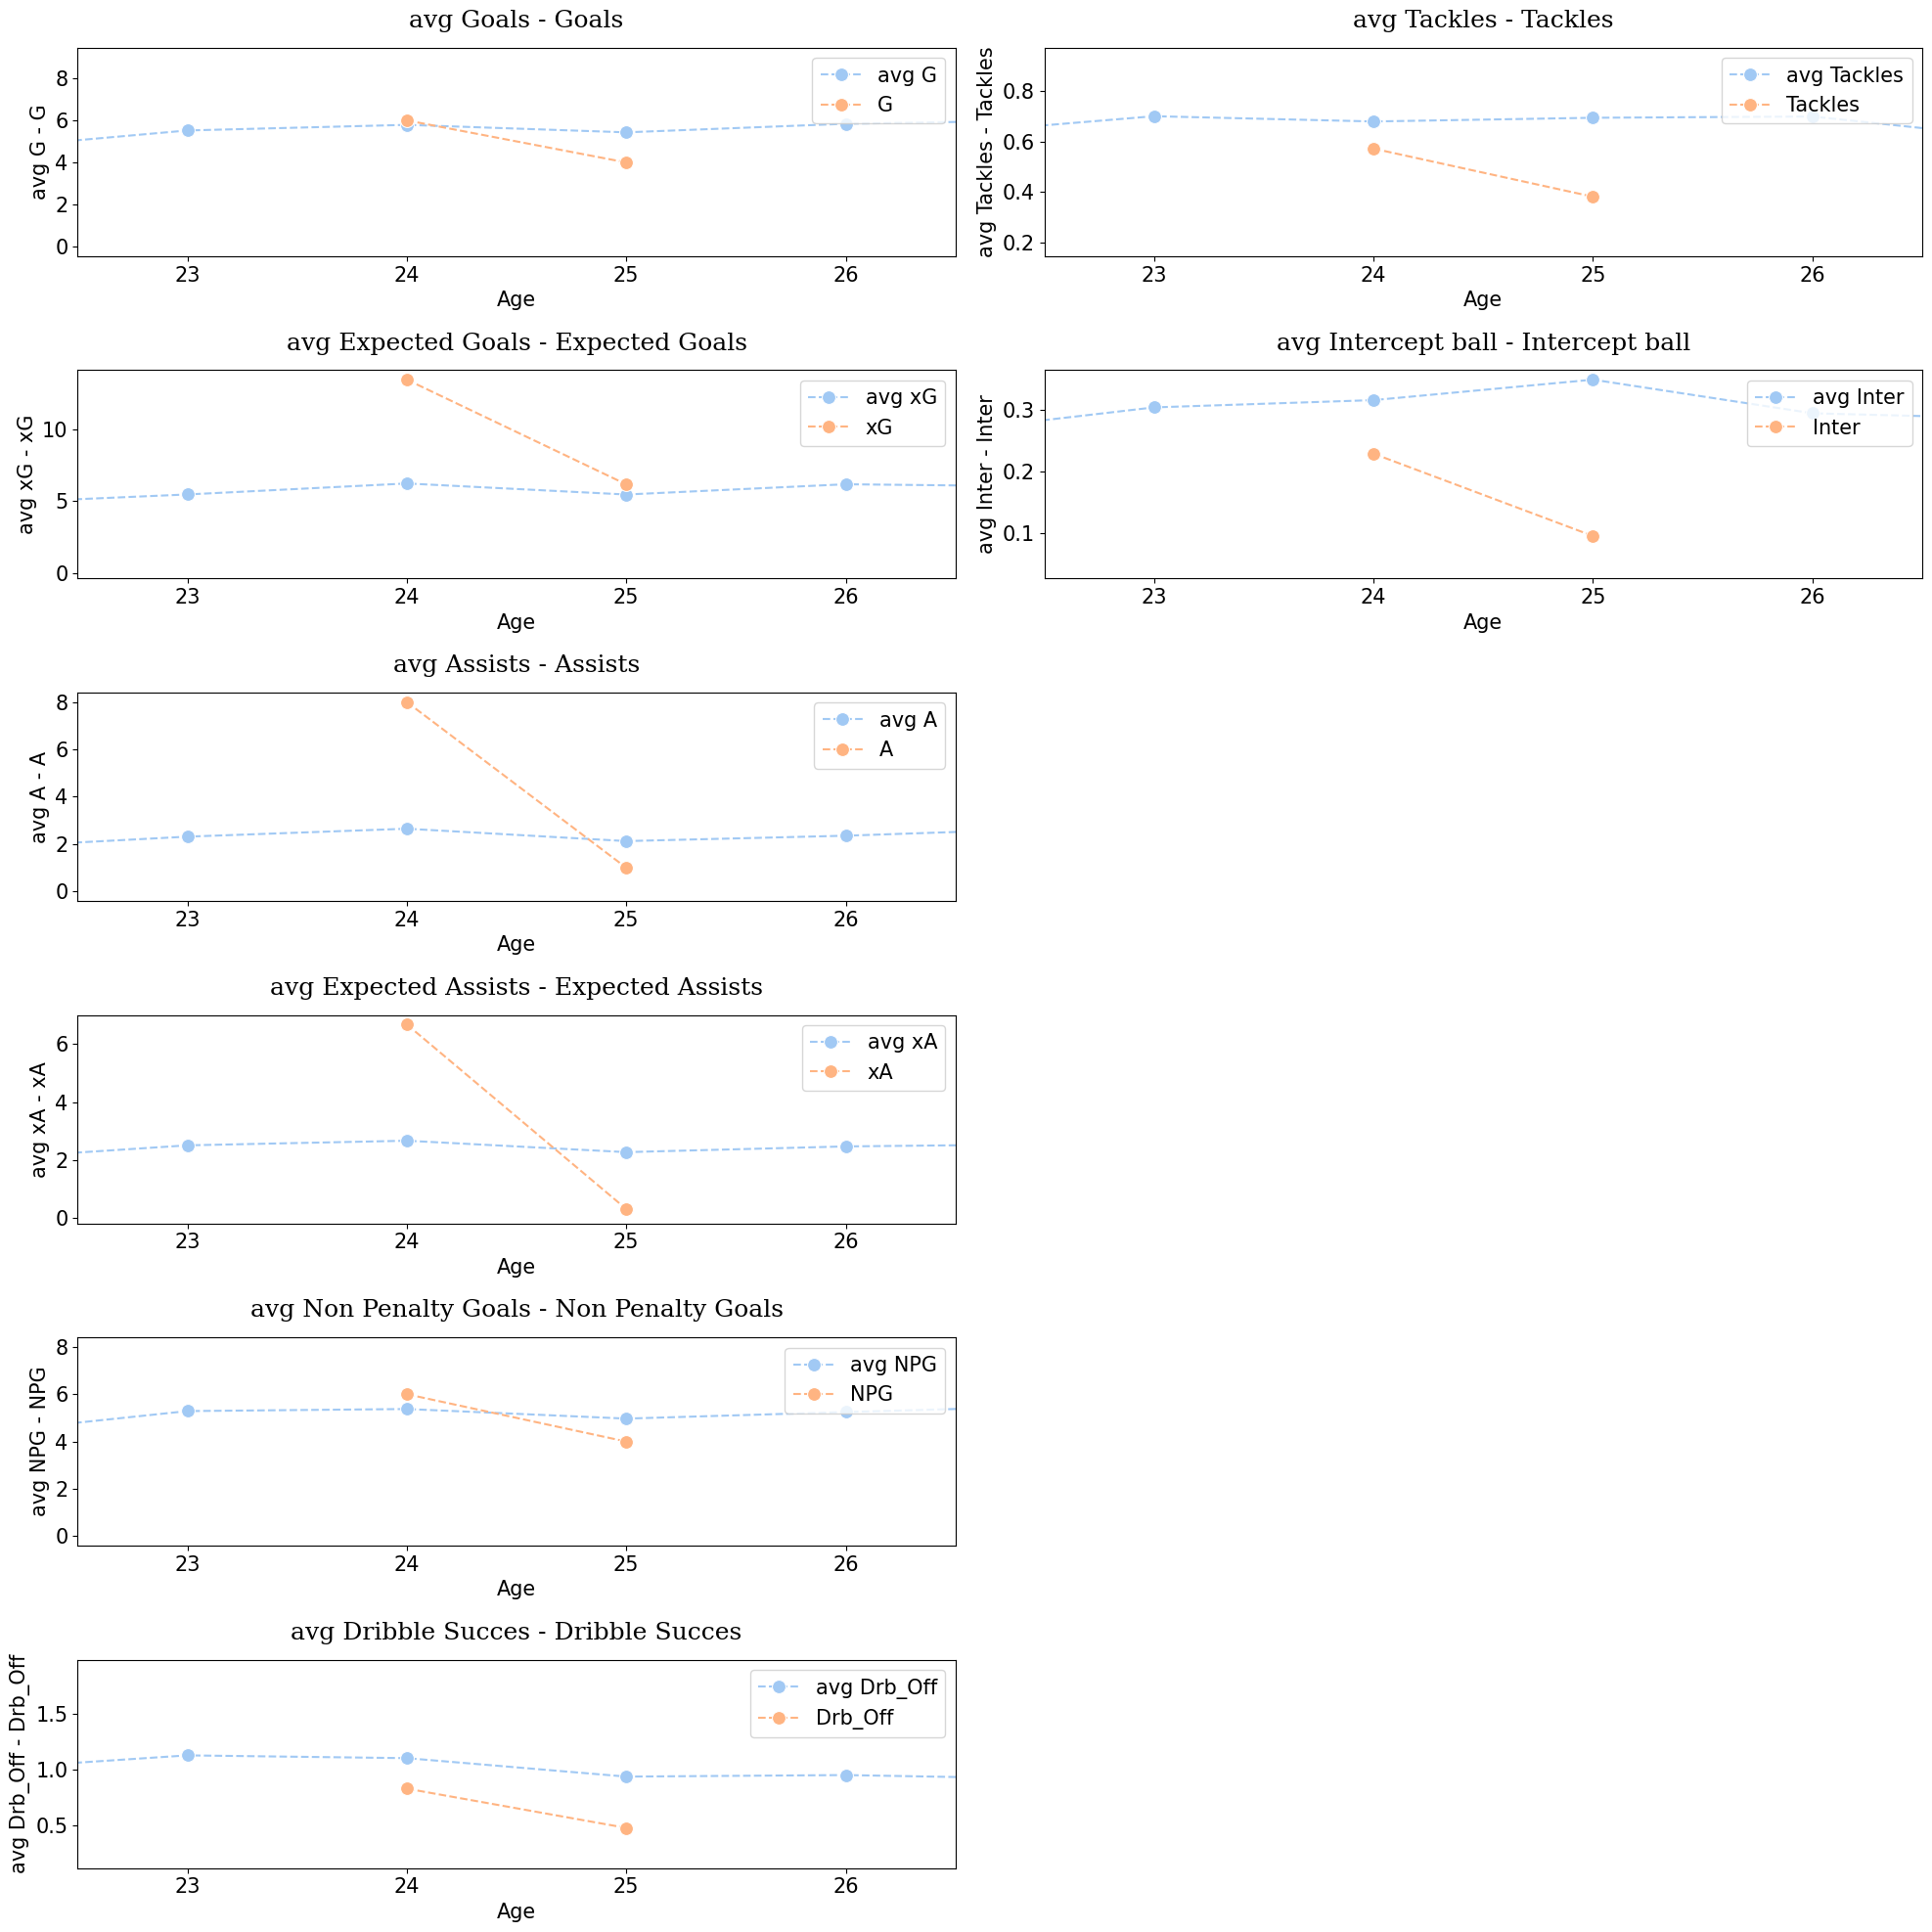

In [74]:
# 각 나이별 평균 수치로 비교
# 특정 선수 지표와 해당 나이대 평균 비교
player_name = "Timo Werner"
one_player = eda_df[eda_df['Name'] == player_name]
position = one_player['Position'].unique()[0]

# 해당 포지션의 평균 값들만 가져옴
position_min_means = eda_df[eda_df.Min > apps_mean].groupby(['Position', 'Age']).mean()
means_df = position_min_means.loc[position]



###### 데이터 시각화 ######
offensive_data_len = len(feature_dict[position]['Offensive'])
defensive_data_len = len(feature_dict[position]['Defensive'])

plt.figure(figsize = (20, 20))
plt.rc('font', size= 15)
    
# offensive 시각화
# 플롯 위치 인덱스 초기화
plot_idx = 1
for feat in feature_dict[position]['Offensive']:
    # 플롯을 그릴 서브플롯 설정
    plt.subplot(6, 2, plot_idx)

    sns.set_palette('pastel')
    plt.title(f'avg {feature_name_dict[feat]} - {feature_name_dict[feat]}', pad = 15, fontfamily = 'serif')
    plt.ylabel(f'avg {feat} - {feat}')
    
    plt.xticks(list(means_df.index))
    # 선수의 데이터 조건에 따라 xlim을 설정에 리턴 해주는 함수
    plt.xlim(return_xlim(one_player))
    
    sns.lineplot(data = means_df, x = 'Age', y = feat, label = f'avg {feat}',
                 linestyle='--', marker='o', markersize = 10)
    sns.lineplot(data = one_player, x = 'Age', y = feat, label = f'{feat}',
                 linestyle='--', marker='o', markersize = 10)
    plt.legend(loc = 'upper right')

    # 다음 플롯을 그리기 위해 증가
    plot_idx += 2    

# defensive 시각화
# 플롯 위치 인덱스 초기화
plot_idx = 2
for feat in feature_dict[position]['Defensive']:
    # 플롯을 그릴 서브플롯 설정
    plt.subplot(6, 2, plot_idx)

    sns.set_palette('pastel')
    plt.title(f'avg {feature_name_dict[feat]} - {feature_name_dict[feat]}', pad = 15, fontfamily = 'serif')
    plt.ylabel(f'avg {feat} - {feat}')

    plt.xticks(list(means_df.index))
   # 선수의 데이터 조건에 따라 xlim을 설정에 리턴 해주는 함수
    plt.xlim(return_xlim(one_player))
        
    sns.lineplot(data = means_df, x = 'Age', y = feat, label = f'avg {feat}',
                 linestyle='--', marker='o', markersize = 10)
    sns.lineplot(data = one_player, x = 'Age', y = feat, label = f'{feat}',
                 linestyle='--', marker='o', markersize = 10)
    plt.legend(loc = 'upper right')

    # 다음 플롯을 그리기 위해 증가
    plot_idx += 2


plt.tight_layout()
# plt.show()
plt.savefig(f'{player_name}.png')

In [73]:
eda_df[eda_df['Name'].str.contains('Werner')]

,Player Id,Name,Birth Year,Age,Team,Position,year,Weekly Salary,Base Salary,ADJ Salary,...,Tackles,Inter,Fouls,Offsides,Clear,Drb_Def,Blocks,AvgP,PS%,Age Lev
3285,130903,Timo Werner,1996,24,Chelsea,Forward,2020,270000.0,14040000.0,15152256.0,...,0.571429,0.228571,0.80000,0.0,0.171429,1.028571,0.028571,22.257143,78.818999,24
3972,130903,Timo Werner,1996,25,Chelsea,Forward,2021,270000.0,14040000.0,14040000.0,...,0.380952,0.095238,0.52381,0.0,0.190476,0.857143,0.000000,17.714286,78.225806,25


/var/folders/5r/gwhqhzlx7g5_xdjhhpzr42_h0000gn/T/ipykernel_78204/2008831833.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  position_min_means = eda_df[eda_df.Min > min_mean].groupby(['Position', 'Age Lev']).mean()


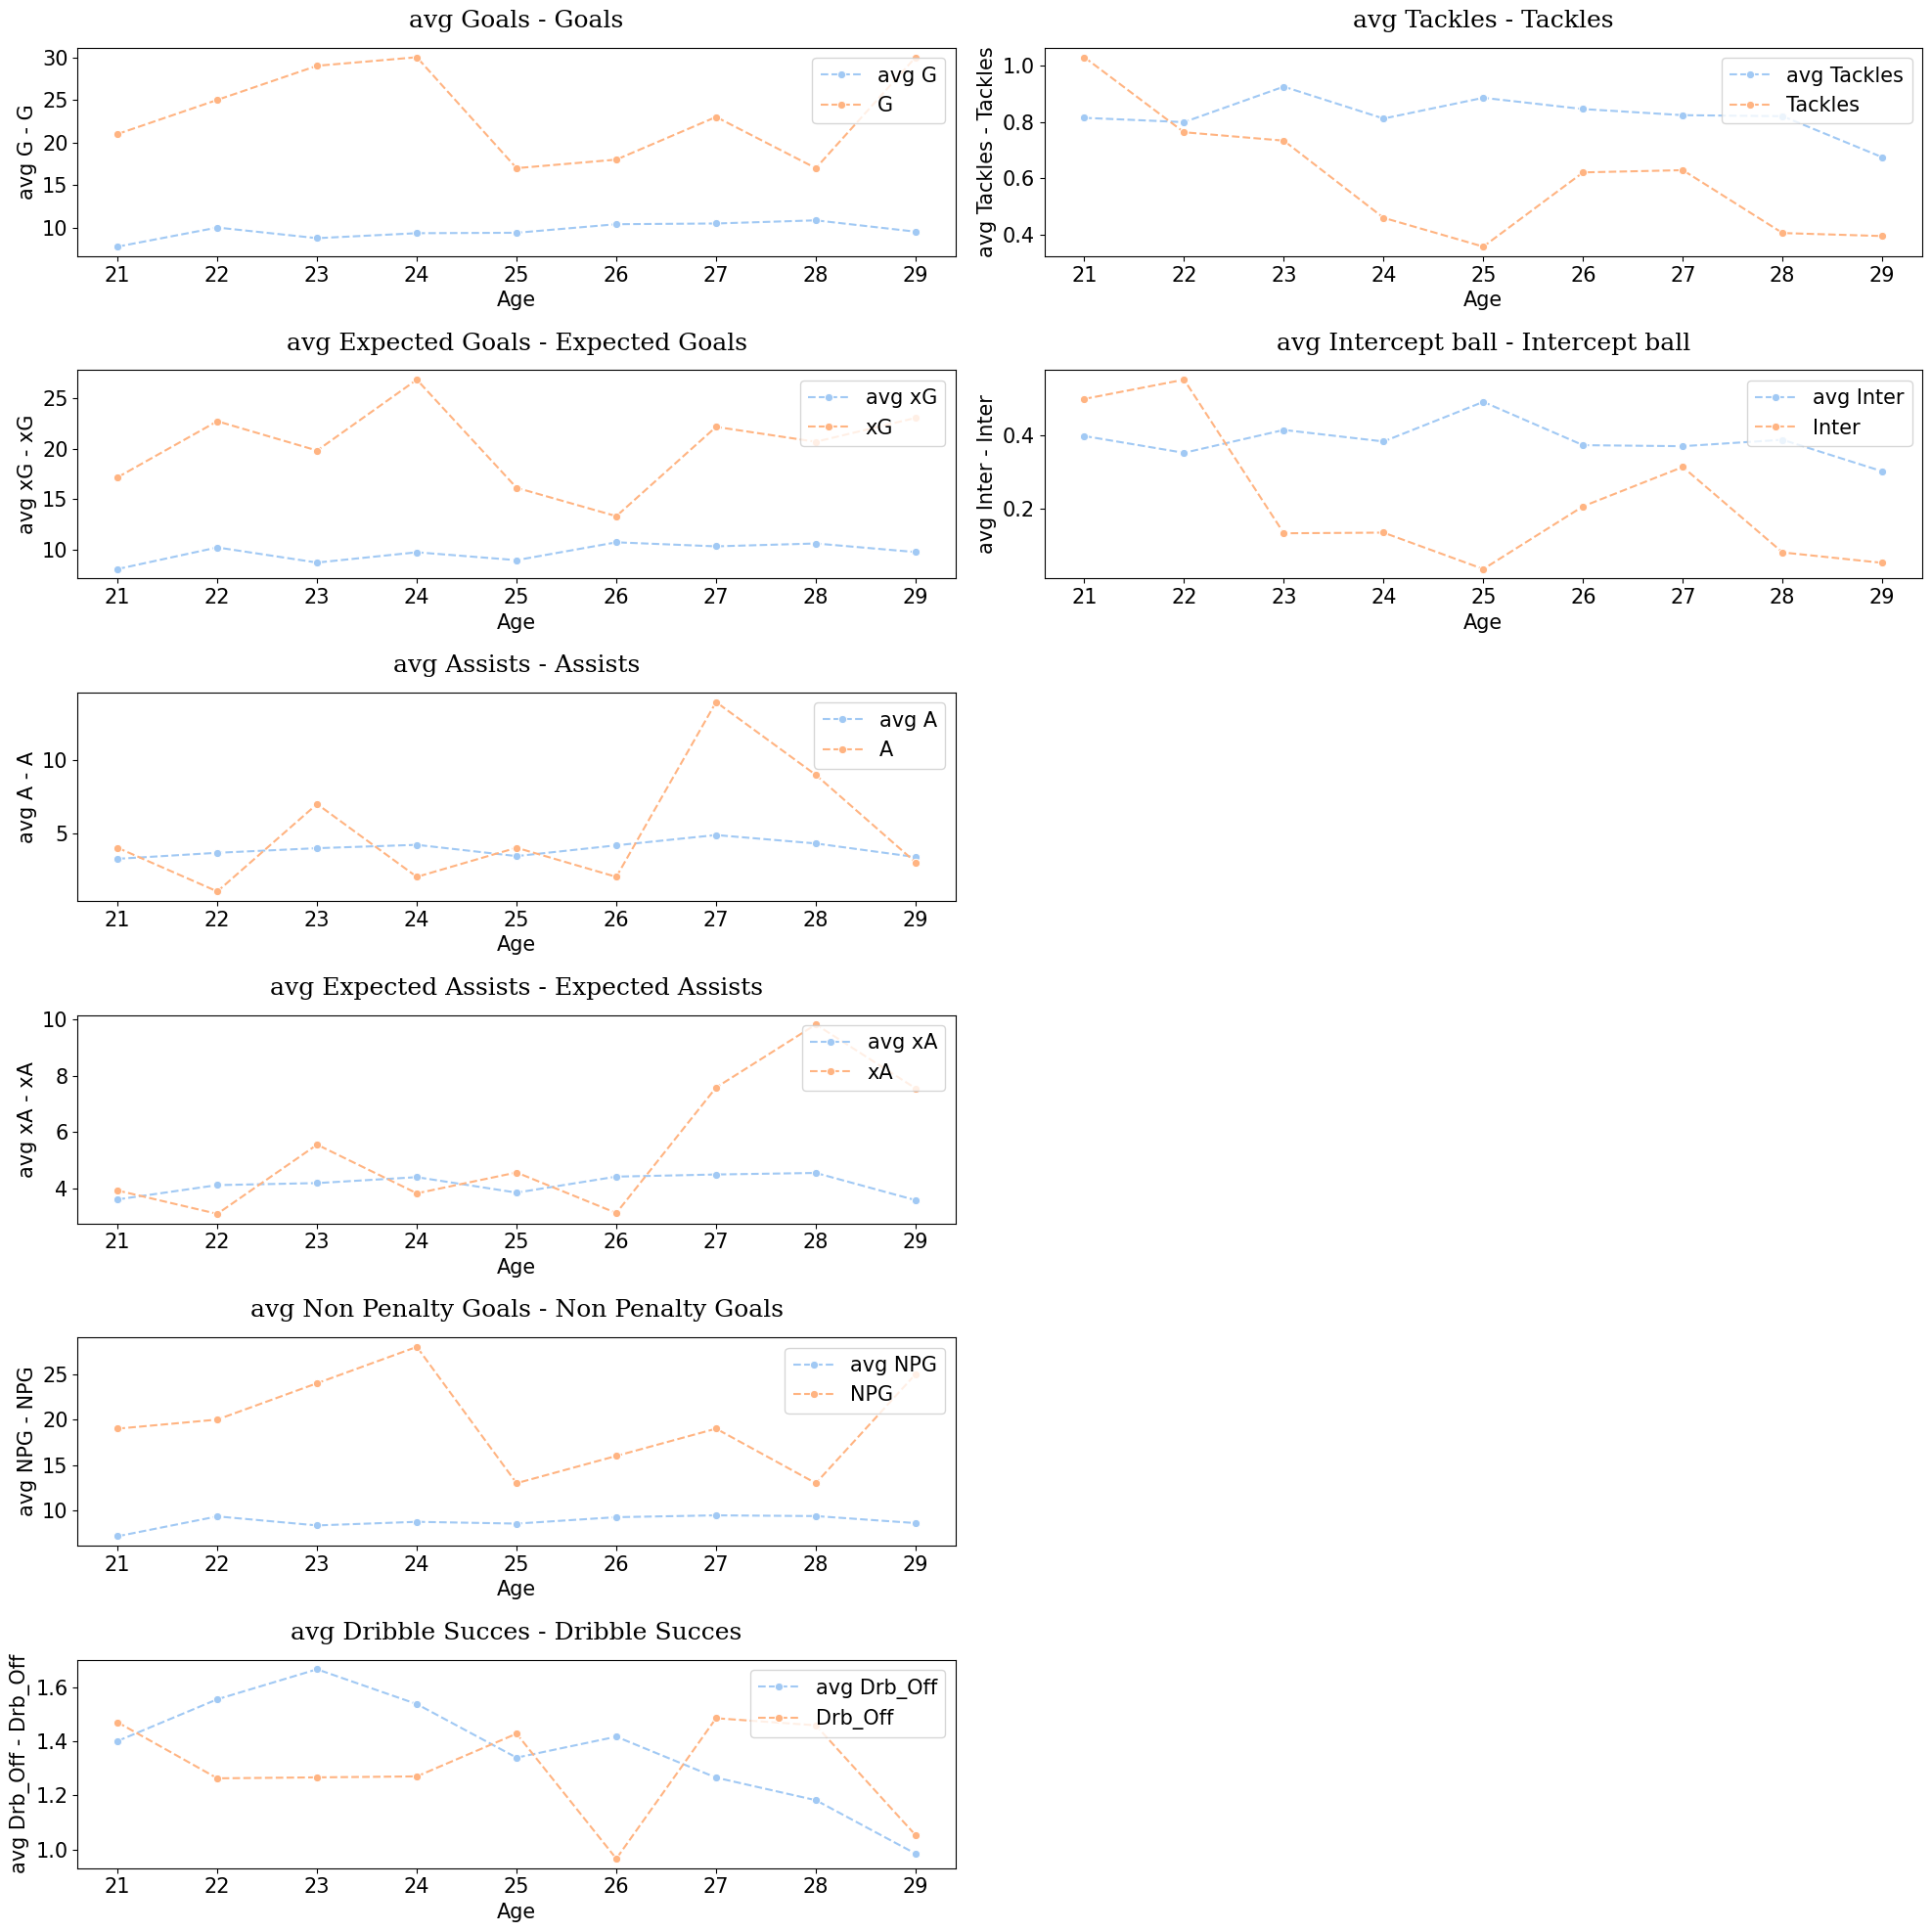

In [75]:
# Age Lev 기준으로 나눈 것
# 특정 선수 지표와 해당 나이대 평균 비교
player_name = "Harry Kane"
one_player = eda_df[eda_df['Name'] == player_name]
position = one_player['Position'].unique()[0]

# 해당 포지션의 평균 값들만 가져옴
position_min_means = eda_df[eda_df.Min > min_mean].groupby(['Position', 'Age Lev']).mean()
position_min_means = position_min_means.drop(columns = 'Age')
position_min_means.loc[position]

# 나이 범위에 맞추어 평균 값 데이터 만들기
means_list = [['Age', 'Age Lev'] + list(position_min_means.columns)]
for age in one_player['Age'].unique():
    age_lev = get_age_lev(age)
    temp = list(position_min_means.loc[(position, age_lev)])
    means_list.append([age, age_lev] + temp)
means_df = pd.DataFrame(means_list[1:], columns = means_list[0])




###### 데이터 시각화 ######
offensive_data_len = len(feature_dict[position]['Offensive'])
defensive_data_len = len(feature_dict[position]['Defensive'])

plt.figure(figsize = (20, 20))
plt.rc('font', size= 15)
    
# offensive 시각화
# 플롯 위치 인덱스 초기화
plot_idx = 1
for feat in feature_dict[position]['Offensive']:
    # 플롯을 그릴 서브플롯 설정
    plt.subplot(6, 2, plot_idx)

    sns.set_palette('pastel')
    plt.title(f'avg {feature_name_dict[feat]} - {feature_name_dict[feat]}', pad = 15, fontfamily = 'serif')
    plt.ylabel(f'avg {feat} - {feat}')

    plt.xticks(one_player['Age'].unique())
    sns.lineplot(data = means_df, x = 'Age', y = feat, label = f'avg {feat}', linestyle='--', marker='o')
    sns.lineplot(data = one_player, x = 'Age', y = feat, label = f'{feat}', linestyle='--', marker='o')
    plt.legend(loc = 'upper right')

    # 다음 플롯을 그리기 위해 증가
    plot_idx += 2    

# defensive 시각화
# 플롯 위치 인덱스 초기화
plot_idx = 2
for feat in feature_dict[position]['Defensive']:
    # 플롯을 그릴 서브플롯 설정
    plt.subplot(6, 2, plot_idx)

    sns.set_palette('pastel')
    plt.title(f'avg {feature_name_dict[feat]} - {feature_name_dict[feat]}', pad = 15, fontfamily = 'serif')
    plt.ylabel(f'avg {feat} - {feat}')

    plt.xticks(one_player['Age'].unique())
    sns.lineplot(data = means_df, x = 'Age', y = feat, label = f'avg {feat}', linestyle='--', marker='o')
    sns.lineplot(data = one_player, x = 'Age', y = feat, label = f'{feat}', linestyle='--', marker='o')
    plt.legend(loc = 'upper right')

    # 다음 플롯을 그리기 위해 증가
    plot_idx += 2


plt.tight_layout()
# plt.show()
plt.savefig(f'{player_name}.png')

## 선수의 특정 지표들과 연봉 테이블 시각화

In [17]:
# player_name = "Gareth Bale"
player_name = "Kevin De Bruyne"

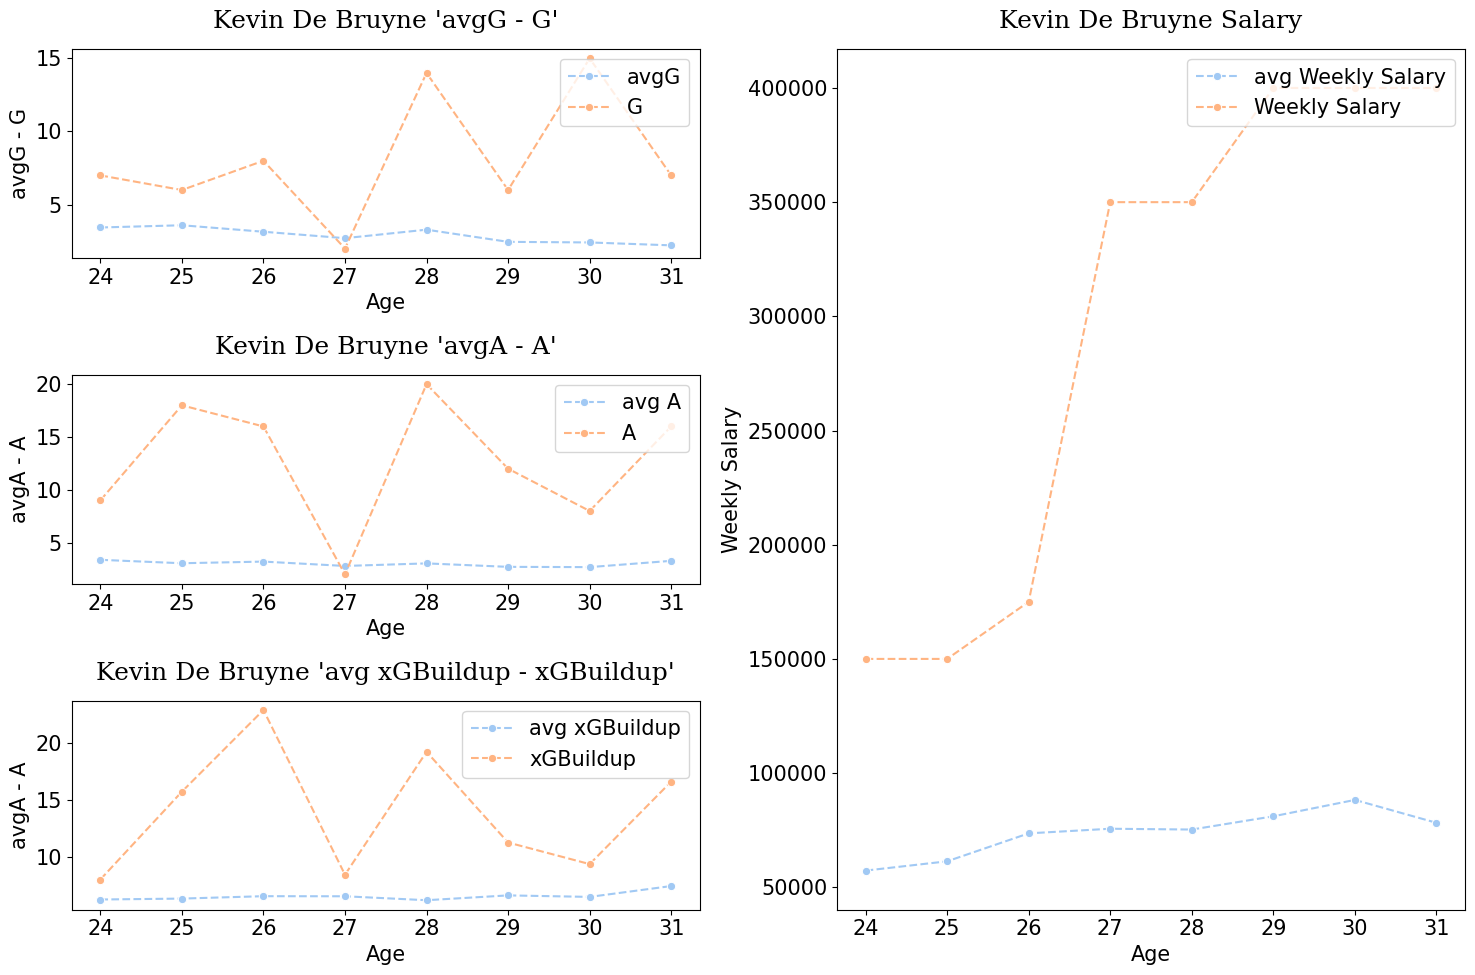

In [18]:
# 특정 선수 지표와 해당 나이대 평균 비교
# player_name = "Son Heung-Min"
one_player = eda_df[eda_df['Name'] == player_name]
position = one_player['Position'].unique()[0]

# 해당 포지션의 평균 값들만 가져옴
position_min_means.loc[position]

# 나이 범위에 맞추어 평균 값 데이터 만들기
means_list = [['Age', 'Age Lev'] + list(position_min_means.columns)]
for age in one_player['Age'].unique():
    age_lev = get_age_lev(age)
    temp = list(position_min_means.loc[(position, age_lev)])
    means_list.append([age, age_lev] + temp)
means_df = pd.DataFrame(means_list[1:], columns = means_list[0])

plt.figure(figsize = (15, 10))

# avgG - G
plt.subplot(3, 2, 1)
sns.set_palette('pastel')
plt.title(f'{player_name} \'avgG - G\'', pad = 15, fontfamily = 'serif')
plt.ylabel('avgG - G')

plt.xticks(one_player['Age'].unique())
sns.lineplot(data = means_df, x = 'Age', y = 'G', label = 'avgG', linestyle='--', marker='o')
sns.lineplot(data = one_player, x = 'Age', y = 'G', label = 'G', linestyle='--', marker='o')
plt.legend(loc = 'upper right')

# avgA - A
plt.subplot(3, 2, 3)
sns.set_palette('pastel')
plt.title(f'{player_name} \'avgA - A\'', pad = 15, fontfamily = 'serif')
plt.ylabel('avgA - A')

plt.xticks(one_player['Age'].unique())
sns.lineplot(data = means_df, x = 'Age', y = 'A', label = 'avg A', linestyle='--', marker='o')
sns.lineplot(data = one_player, x = 'Age', y = 'A', label = 'A', linestyle='--', marker='o')
plt.legend(loc = 'upper right')

# avg xGBuildup - xGBuildup
plt.subplot(3, 2, 5)
sns.set_palette('pastel')
plt.title(f'{player_name} \'avg xGBuildup - xGBuildup\'', pad = 15, fontfamily = 'serif')
plt.ylabel('avgA - A')

plt.xticks(one_player['Age'].unique())
sns.lineplot(data = means_df, x = 'Age', y = 'xGBuildup', label = 'avg xGBuildup', linestyle='--', marker='o')
sns.lineplot(data = one_player, x = 'Age', y = 'xGBuildup', label = 'xGBuildup', linestyle='--', marker='o')
plt.legend(loc = 'upper right')


# Salary
plt.subplot(1, 2, 2)
plt.title(f'{player_name} Salary', pad = 15, fontfamily = 'serif')

plt.xticks(one_player['Age'].unique())
sns.lineplot(data = means_df, x = 'Age', y = 'Weekly Salary', label = 'avg Weekly Salary', linestyle='--', marker='o')
sns.lineplot(data = one_player, x = 'Age', y = 'Weekly Salary', label = 'Weekly Salary', linestyle='--', marker='o')
plt.legend(loc = 'upper right')

plt.tight_layout()
plt.show()

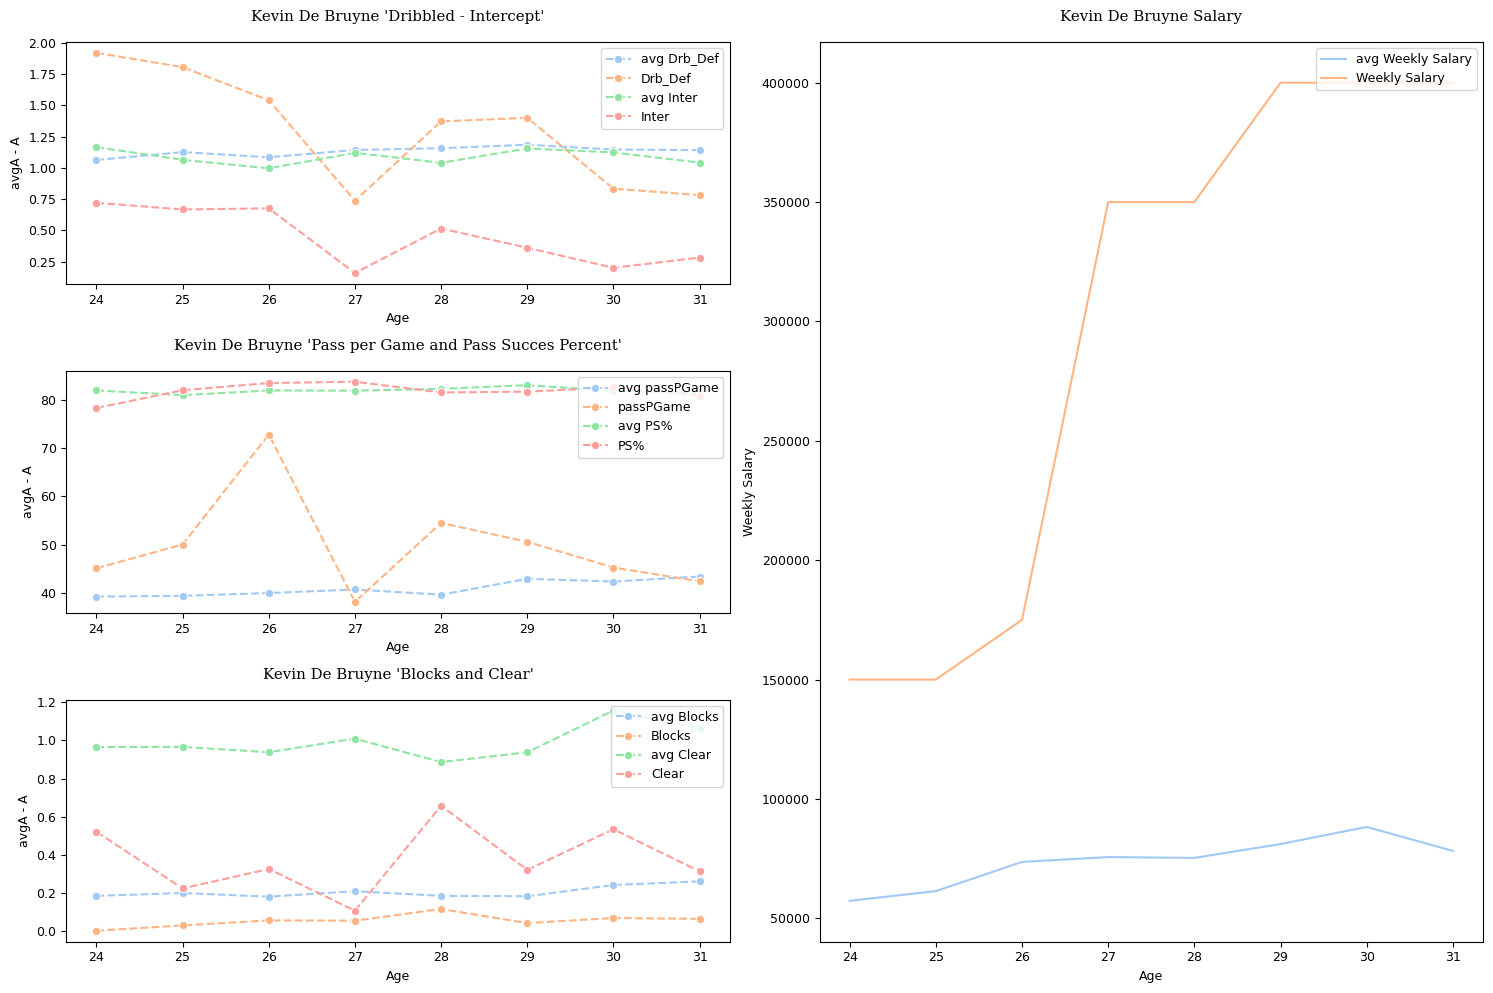

In [19]:
# 특정 선수 지표와 해당 나이대 평균 비교
# player_name = "Luke Ayling"
one_player = eda_df[eda_df['Name'] == player_name]
position = one_player['Position'].unique()[0]

# 해당 포지션의 평균 값들만 가져옴
position_min_means.loc[position]

# 나이 범위에 맞추어 평균 값 데이터 만들기
means_list = [['Age', 'Age Lev'] + list(position_min_means.columns)]
for age in one_player['Age'].unique():
    age_lev = get_age_lev(age)
    temp = list(position_min_means.loc[(position, age_lev)])
    means_list.append([age, age_lev] + temp)
means_df = pd.DataFrame(means_list[1:], columns = means_list[0])

plt.figure(figsize = (15, 10))
plt.rc('font', size= 9)


# Drb_Def and tackle
plt.subplot(3, 2, 1)
sns.set_palette('pastel')
plt.title(f'{player_name} \'Dribbled - Intercept\'', pad = 15, fontfamily = 'serif')
plt.ylabel('avgA - A')

plt.xticks(one_player['Age'].unique())
sns.lineplot(data = means_df, x = 'Age', y = 'Drb_Def', label = 'avg Drb_Def', linestyle='--', marker='o')
sns.lineplot(data = one_player, x = 'Age', y = 'Drb_Def', label = 'Drb_Def', linestyle='--', marker='o')
sns.lineplot(data = means_df, x = 'Age', y = 'Inter', label = 'avg Inter', linestyle='--', marker='o')
sns.lineplot(data = one_player, x = 'Age', y = 'Inter', label = 'Inter', linestyle='--', marker='o')
plt.legend(loc = 'upper right')

# avg pass stat - stat
plt.subplot(3, 2, 3)
sns.set_palette('pastel')
plt.title(f'{player_name} \'Pass per Game and Pass Succes Percent\'', pad = 15, fontfamily = 'serif')
plt.ylabel('avgA - A')

plt.xticks(one_player['Age'].unique())
sns.lineplot(data = means_df, x = 'Age', y = 'AvgP', label = 'avg passPGame', linestyle='--', marker='o')
sns.lineplot(data = one_player, x = 'Age', y = 'AvgP', label = 'passPGame', linestyle='--', marker='o')
sns.lineplot(data = means_df, x = 'Age', y = 'PS%', label = 'avg PS%', linestyle='--', marker='o')
sns.lineplot(data = one_player, x = 'Age', y = 'PS%', label = 'PS%', linestyle='--', marker='o')
plt.legend(loc = 'upper right')

# avg Defensive stat - stat
plt.subplot(3, 2, 5)
sns.set_palette('pastel')
plt.title(f'{player_name} \'Blocks and Clear\'', pad = 15, fontfamily = 'serif')
plt.ylabel('avgA - A')

plt.xticks(one_player['Age'].unique())
# sns.lineplot(data = means_df, x = 'Age', y = 'Tackles', label = 'avg Tackles', linestyle='--', marker='o')
# sns.lineplot(data = one_player, x = 'Age', y = 'Tackles', label = 'Tackles', linestyle='--', marker='o')
sns.lineplot(data = means_df, x = 'Age', y = 'Blocks', label = 'avg Blocks', linestyle='--', marker='o')
sns.lineplot(data = one_player, x = 'Age', y = 'Blocks', label = 'Blocks', linestyle='--', marker='o')
sns.lineplot(data = means_df, x = 'Age', y = 'Clear', label = 'avg Clear', linestyle='--', marker='o')
sns.lineplot(data = one_player, x = 'Age', y = 'Clear', label = 'Clear', linestyle='--', marker='o')
plt.legend(loc = 'upper right')

# Salary
plt.subplot(1, 2, 2)
plt.title(f'{player_name} Salary', pad = 15, fontfamily = 'serif')

plt.xticks(one_player['Age'].unique())
sns.lineplot(data = means_df, x = 'Age', y = 'Weekly Salary', label = 'avg Weekly Salary')
sns.lineplot(data = one_player, x = 'Age', y = 'Weekly Salary', label = 'Weekly Salary')
plt.legend(loc = 'upper right')

plt.tight_layout()
plt.show()
# plt.savefig(f'{player_name}.png')